<a href="https://colab.research.google.com/github/RavenMorgan/Tweets-Sentiment-Analysis-/blob/main/Sentiments_Analysis_with_LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini projet en Deep learning

## Dernier délai : 18 Décembre 2023

## Sujet : analyse de sentiments

Le traitement automatique de la langue est un domaine multidisciplinaire impliquant la
linguistique, l'informatique et l'intelligence artificielle. Il vise à créer des outils de traitement de
la langue naturelle pour diverses applications. Parmi ces applications, nous pouvons citer celles
qui relèvent du traitement des réseaux sociaux. Les sites de médias sociaux, tels que Twitter,
sont une source riche de nombreux types d'informations, notamment en matière de santé.
Ce projet consiste à développer des modèles de classification des sentiments (positive, negative
ou neutre) sur les réseaux sociaux avec trois architectures différentes (LSTM, BERT, et GPT),
et à évaluer le meilleur d’entre eux.

Dataset est le site Kaggle:
*training.1600000.processed.noemoticon.csv*

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


### Imports

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load dataset

In [ ]:
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)
df.head()

0           1                             2         3                4  \
0  0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                                   5  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....

In [ ]:
# On supprime les colonnes inutiles
df = df.drop([1,2,3,4], axis=1)
# On garde le sentiment et le texte
df.columns= ['sentiment','text']

Encodage des sentiments : négatif ==> 0 et positif ==> 1

In [ ]:
df.sentiment = df.sentiment.apply(lambda x: 1 if x == 4 else x)

[800000 800000]


Text(0.5, 1.0, 'Sentiment Data Distribution')

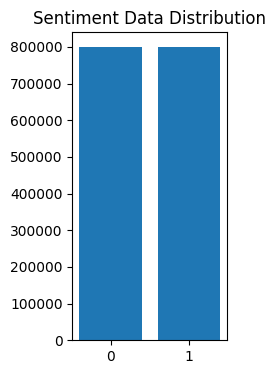

In [ ]:
val_count = df.sentiment.value_counts()
print(val_count.values)

plt.figure(figsize=(2,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

# PREPROCESSING

In [ ]:
def preprocess(text, stem=False):
    stemmer = SnowballStemmer('english')

    # Cleaning corpus
    text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()

    # Delete stopwords
    stop_words = stopwords.words('english')
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
df.text = df.text.apply(lambda x: preprocess(x))
print(df.text)

0               awww bummer shoulda got david carr third day
1          upset update facebook texting might cry result...
2          dived many times ball managed save 50 rest go ...
3                           whole body feels itchy like fire
4                                           behaving mad see
                                 ...                        
1599995                        woke school best feeling ever
1599996             thewdb com cool hear old walt interviews
1599997                      ready mojo makeover ask details
1599998    happy 38th birthday boo alll time tupac amaru ...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, Length: 1600000, dtype: object


In [ ]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

# TOKENIZATION

Embedding = traiter les données pour les convertir sous formes de vecteurs

In [ ]:
from keras.preprocessing.text import Tokenizer

# Create tokenizer
tokenizer = Tokenizer()
# Fit texts
tokenizer.fit_on_texts(df.text)
# Convertir le texte en séquences d'entiers
sequences = tokenizer.texts_to_sequences(df.text)
# Calcul vocab size
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index)

# Afficher les résultats
# print("Texte original :", df.text)
# print("Séquences d'entiers :", sequences)
print("Vocab size :", vocab_size)
print("Index des mots :", word_index)

Vocab size : 335507
Index des mots : {'good': 1, 'day': 2, 'get': 3, 'like': 4, 'go': 5, 'quot': 6, 'today': 7, 'work': 8, 'love': 9, 'going': 10, 'got': 11, 'lol': 12, 'time': 13, 'back': 14, 'u': 15, 'one': 16, 'know': 17, 'im': 18, 'really': 19, 'amp': 20, 'see': 21, 'night': 22, 'still': 23, '2': 24, 'well': 25, 'new': 26, 'want': 27, 'think': 28, 'home': 29, 'thanks': 30, 'oh': 31, 'much': 32, 'miss': 33, 'need': 34, 'last': 35, 'morning': 36, 'tomorrow': 37, 'hope': 38, 'great': 39, 'twitter': 40, '3': 41, 'haha': 42, 'feel': 43, 'sad': 44, 'fun': 45, 'wish': 46, 'sleep': 47, 'right': 48, 'bad': 49, 'would': 50, 'happy': 51, 'sorry': 52, 'tonight': 53, 'come': 54, 'make': 55, 'way': 56, 'getting': 57, 'though': 58, 'gonna': 59, 'nice': 60, 'better': 61, 'watching': 62, 'yeah': 63, 'wait': 64, 'bed': 65, 'could': 66, 'week': 67, 'school': 68, 'people': 69, 'hate': 70, 'days': 71, 'even': 72, 'hey': 73, '4': 74, 'yes': 75, 'next': 76, 'lt': 77, 'weekend': 78, 'awesome': 79, 'dont':

# PADDING

In [ ]:
from keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = 30
MAX_NB_WORDS = 100000

pad_sentences = pad_sequences(sequences, maxlen = MAX_SEQUENCE_LENGTH,  padding = "post")

print(pad_sentences.shape)

(1600000, 30)


In [ ]:
labels = df.sentiment.unique().tolist()
print(labels)

[0, 1]


# DATA SPLIT

20% de test | 80% d'entrainement

In [ ]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pad_sentences, df.sentiment, test_size=1-TRAIN_SIZE,
                                         random_state=7)

print("Training X Shape:",X_train.shape)
print("Testing X Shape:",X_test.shape)
print("Training X Shape:",y_train.shape)
print("Testing X Shape:",y_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)
Training X Shape: (1280000,)
Testing X Shape: (320000,)


## ENCODER

In [ ]:
encoder = LabelEncoder()
encoder.fit(y_train)

y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


# EMBEDDING

Download pre-trainted

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-12-23 16:08:40--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-12-23 16:08:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-12-23 16:08:40--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glov

In [ ]:
GLOVE_EMB = '/kaggle/working/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [ ]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

# MODEL

## Imports

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

## TRAINING

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [ ]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(X_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
1250/1250 [==============================] - 133s 94ms/step - loss: 0.5186 - accuracy: 0.7399 - val_loss: 0.4826 - val_accuracy: 0.7649 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 117s 94ms/step - loss: 0.4865 - accuracy: 0.7631 - val_loss: 0.4696 - val_accuracy: 0.7744 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 116s 93ms/step - loss: 0.4761 - accuracy: 0.7700 - val_loss: 0.4661 - val_accuracy: 0.7776 - lr: 0.0010
Epoch 4/10
1250/1250 [==============================] - 116s 93ms/step - loss: 0.4699 - accuracy: 0.7741 - val_loss: 0.4619 - val_accuracy: 0.7784 - lr: 0.0010
Epoch 5/10
1250/1250 [==============================] - 116s 92ms/step - loss: 0.4658 - accuracy: 0.7764 - val_loss: 0.4593 - val_accuracy: 0.7803 - lr: 0.0010
Epoch 6/10
1250/1250 [==============================] - 116s 93ms/step - loss: 0.4620 - accuracy: 0.7789 - val_loss: 0.4580 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 7/10
1250/1250 [==================

# MODEL EVALUATION

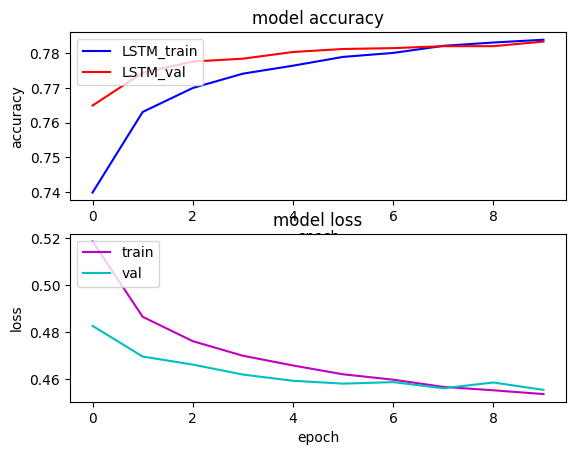

In [ ]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

# EVALUATION

In [ ]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0


scores = model.predict(X_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 3s 62ms/step


## CONFUSION MATRIX

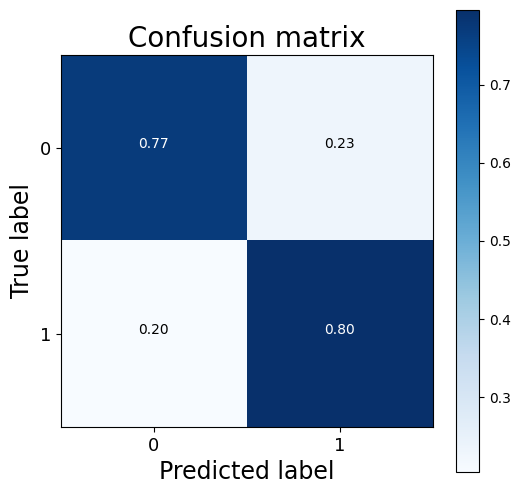

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)


cnf_matrix = confusion_matrix(y_test, y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=labels, title="Confusion matrix")
plt.show()

## Classification scores

In [ ]:
print(classification_report(list(y_test), y_pred_1d))

              precision    recall  f1-score   support

           0       0.79      0.77      0.78    160542
           1       0.78      0.80      0.79    159458

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000

